In [1]:
# ! python3.9 -m pip install --upgrade --target='/home/ldoyle/packages' obspy

In [2]:
import h5py
import cv2
import os
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
from tqdm import tqdm
from matplotlib import gridspec
import matplotlib.pyplot as plt
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

In [3]:
import glob

In [5]:
smoothed_dat = np.load('gaussian_smoothed_11_2_2022_channels_7500_12500South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy')

## fk-filt

In [6]:
from numpy import fft
import numpy as np
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime

In [7]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
# file2 = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231214Z.h5"

f = h5py.File(path+file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

# f = h5py.File(path+file2, 'r')
# data2 = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
# timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
# f.close()

In [25]:
time_subsample = 10
full_dat = data[7500:12500,::time_subsample]

for i in np.arange(8):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231"+str(i+2)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
    timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat = np.hstack((full_dat,data[7500:12500,::time_subsample]))

In [26]:
for i in np.arange(5):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T232"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
    timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat = np.hstack((full_dat,data[7500:12500,::time_subsample]))

In [27]:
full_dat.shape

(5000, 16800)

In [28]:
fk_dat = np.fft.fftn(full_dat)

xf = np.fft.fftfreq(5000, d=2)

In [29]:
tf = np.fft.fftfreq(full_dat.shape[1], d=time_subsample/200)#[:N//2]

X, Y = np.meshgrid(tf,xf)

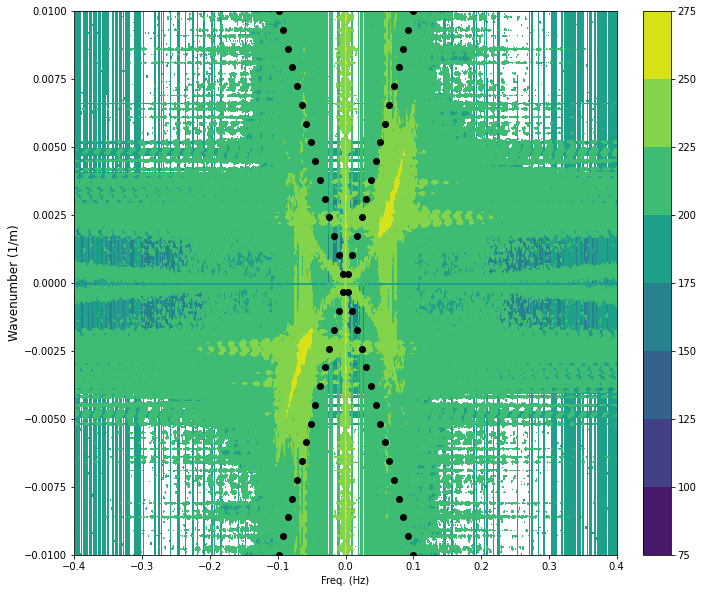

In [53]:
plt.figure(figsize=(12,10))
cp = plt.contourf(X, Y, 10*np.log10(np.abs(fk_dat)**2))

plt.scatter(np.sqrt(9.8*np.linspace(-0.01,0.01,30)*np.tanh(100*np.linspace(-0.01,0.01,30))),
            np.linspace(-0.01,0.01,30), c="k")
plt.scatter(-np.sqrt(9.8*np.linspace(-0.01,0.01,30)*np.tanh(100*np.linspace(-0.01,0.01,30))),
            np.linspace(-0.01,0.01,30), c="k")
plt.xlim(-0.4,0.4)
plt.ylim(-0.01,0.01)
plt.xlabel("Freq. (Hz)")
plt.ylabel("Wavenumber (1/m)",size=12)
plt.colorbar(cp, pad = 0.04)
plt.show()

In [51]:
np.amin(Y[:X.shape[0]//2,:X.shape[1]//2])

0.0

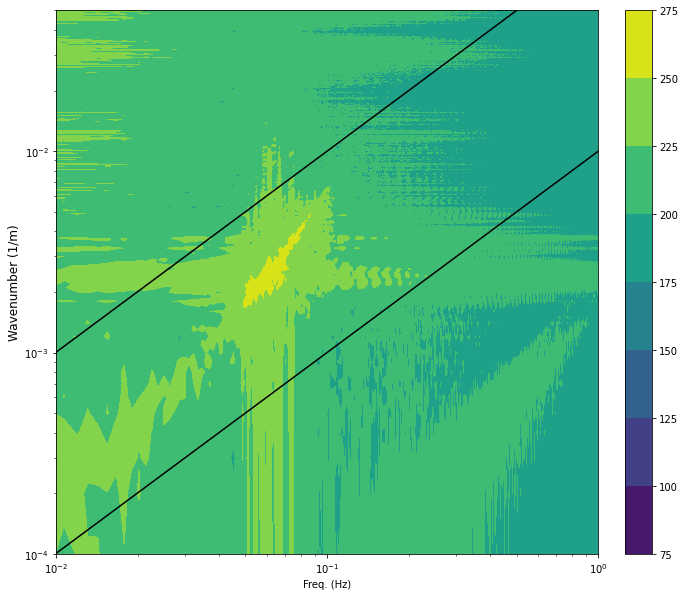

In [52]:
plt.figure(figsize=(12,10))
cp = plt.contourf(X[:X.shape[0]//2,:X.shape[1]//2], Y[:X.shape[0]//2,:X.shape[1]//2], 10*np.log10(np.abs(fk_dat[:X.shape[0]//2,:X.shape[1]//2])**2))
plt.yscale('log')
plt.xscale('log')

plt.xlim(0.01,1.)

plt.ylim(1e-4,0.05)

plt.plot(np.linspace(0.,3,20), (1/10)*np.linspace(0.,3,20),c="k")
plt.plot(np.linspace(0.,3,20), (1/100)*np.linspace(0.,3,20),c="k")

plt.xlabel("Freq. (Hz)")
plt.ylabel("Wavenumber (1/m)",size=12)
plt.colorbar(cp, pad = 0.04)
plt.show()

In [64]:
from obspy.signal import filter as obsfilt

lp_dat = obsfilt.lowpass(full_dat.T, 2, 10, corners=1)#, zerophase=True)

In [59]:

fk_dat = np.fft.fftn(lp_dat.T)
# N=12000
# tf = np.fft.fftfreq(N, d=1/20)#[:N//2]
xf = np.fft.fftfreq(5000, d=2)
tf = np.fft.fftfreq(full_dat.shape[1], d=1/10)#[:N//2]

X, Y = np.meshgrid(tf,xf)


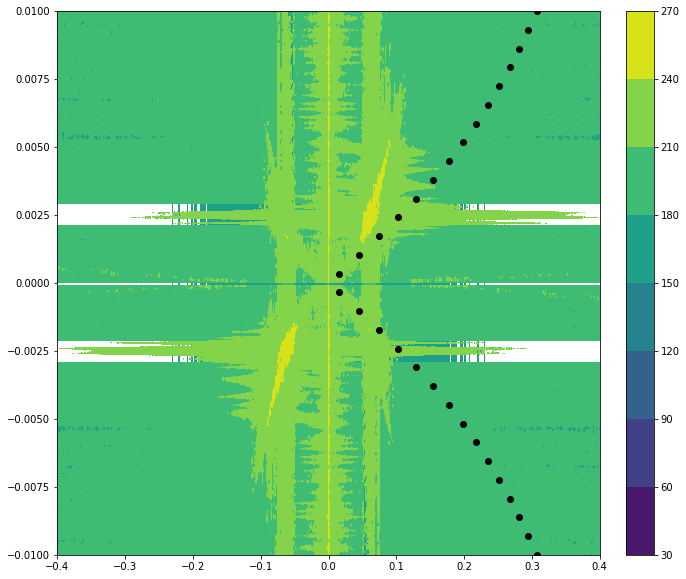

In [60]:
plt.figure(figsize=(12,10))
cp = plt.contourf(X, Y, 10*np.log10(np.abs(fk_dat)**2))
# plt.plot(np.linspace(-3,3,20), (1/1500)*np.linspace(-3,3,20),c="k")
# plt.plot(np.linspace(-3,3,20), (1/300)*np.linspace(-3,3,20),c="k")
plt.scatter(np.sqrt(9.8*np.linspace(-0.01,0.01,30)*np.tanh(200*np.linspace(-0.01,0.01,30))),
            np.linspace(-0.01,0.01,30), c="k")
plt.xlim(-0.4,0.4)
plt.ylim(-0.01,0.01)
plt.colorbar(cp, pad = 0.04)
plt.show()

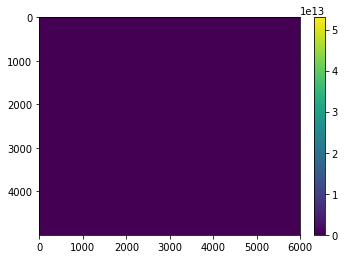

In [67]:
im = plt.imshow(np.imag(fk_dat),vmin=vmin, vmax=vmax)
plt.colorbar(im, pad = 0.04)
plt.show()

In [70]:
lp_dat = obsfilt.lowpass(lp_dat.T, 0.2, 1/2, corners=1)#, zerophase=True)

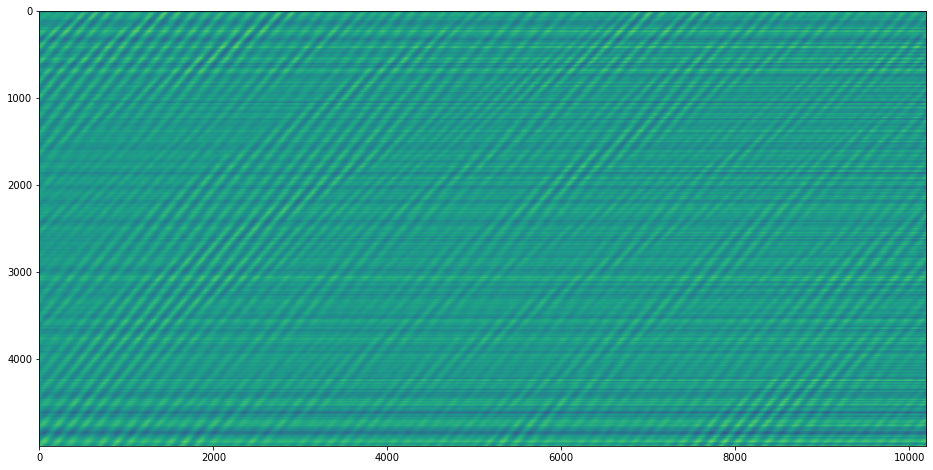

In [13]:
plt.figure(figsize=(20,8))
plt.imshow(full_dat)
plt.show()

In [74]:
np.linalg.norm((lp_dat-full_dat))/np.linalg.norm((full_dat))

0.36093061706692614

In [68]:
np.amax(np.abs(fk_dat))*(10**(-13))

5.296247063978412

In [69]:
np.amin(np.abs(fk_dat))

2993.862210145311

In [70]:
np.real(fk_dat)

array([[ 7.51900422e+11,  3.33758725e+11,  2.18056803e+11, ...,
        -1.12391456e+08, -1.12359940e+08, -1.12283189e+08],
       [ 2.99804394e+12, -1.58544477e+11, -8.44409201e+10, ...,
        -1.28239560e+08, -1.28224666e+08, -1.28198997e+08],
       [ 2.65807628e+12,  6.51719295e+11,  2.37642452e+11, ...,
         1.06805309e+08,  1.06779247e+08,  1.06766833e+08],
       ...,
       [ 4.67076798e+12,  8.36349640e+11,  4.15221483e+11, ...,
        -7.49275210e+06, -7.54158130e+06, -7.61619490e+06],
       [ 2.65807628e+12,  1.20383921e+11,  3.17512107e+10, ...,
         1.06726386e+08,  1.06755154e+08,  1.06766833e+08],
       [ 2.99804394e+12,  5.61281321e+11,  2.92244735e+11, ...,
        -1.28189890e+08, -1.28192314e+08, -1.28198997e+08]])

In [75]:
filt_fk = np.zeros(fk_dat.shape).astype(np.complex128)
shift_fk = fft.fftshift(fk_dat,1)
for i in range(fk_dat.shape[0]):
#     dig = np.amin()
    bound =i//6
    filt_fk[-i,3000-bound:3000+bound] = shift_fk[-i,3000-bound:3000+bound]
    if i<3000:
        filt_fk[-i,3000+i:] = shift_fk[-i,3000+i:]
        filt_fk[-i,:3000-i] = shift_fk[-i,:3000-i]

<ipython-input-76-35442f06997e>:3: RuntimeWarning: divide by zero encountered in log
  im = plt.imshow(np.log(np.abs(filt_fk)**2))#,vmin=vmin, vmax=vmax)


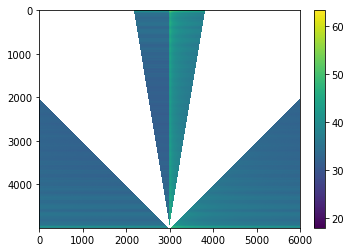

In [76]:
vmin=0
vmax=np.amax(np.abs(fk_dat))
im = plt.imshow(np.log(np.abs(filt_fk)**2))#,vmin=vmin, vmax=vmax)
plt.colorbar(im, pad = 0.04)
plt.show()

In [77]:
fk_inv = fft.irfftn(fft.ifftshift(filt_fk,1))

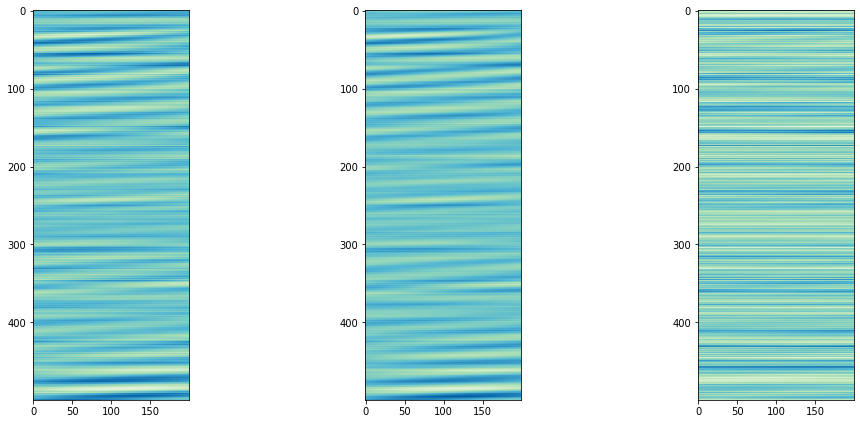

In [55]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (14,6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
vmin=np.amin(sliced_data)
vmax=np.amax(sliced_data)
im = ax1.imshow(sliced_data[::10,:2000:10], vmin=vmin, vmax=vmax,
                cmap = 'GnBu')

im = ax2.imshow(filtered_data_unsure.T[::10,:2000:10], vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
im = ax3.imshow(filtered_data_unsure.T[::10,:2000:10]-sliced_data[::10,:2000:10], #vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
plt.show()

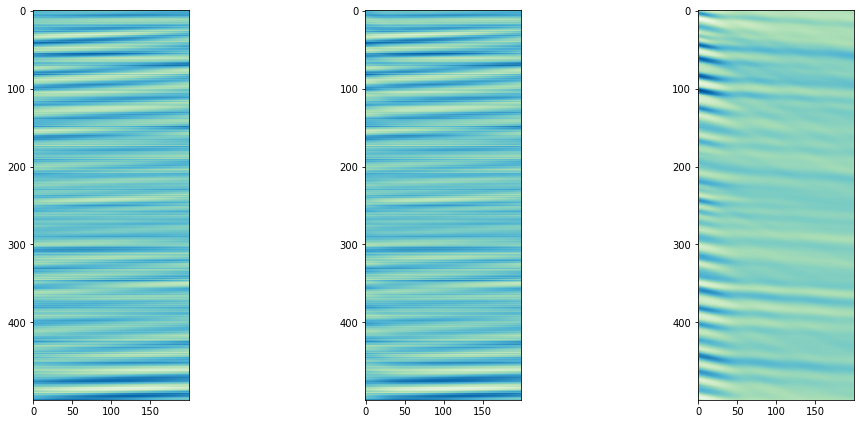

In [78]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (14,6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
vmin=np.amin(sliced_data)
vmax=np.amax(sliced_data)
im = ax1.imshow(sliced_data[::10,:2000:10], vmin=vmin, vmax=vmax,
                cmap = 'GnBu')

im = ax2.imshow(fk_inv[::10,:2000:10], vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
im = ax3.imshow(fk_inv[::10,:2000:10]-sliced_data[::10,:2000:10], #vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
plt.show()

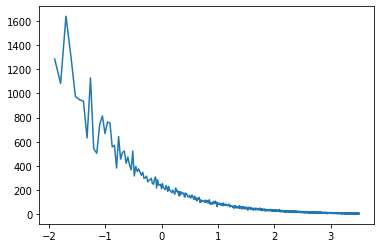

In [71]:
N=12000
# yf1 = np.mean(fft.fft(data),axis=0)
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fft.fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[8:-4000],2.0/N * np.abs(yf1[1:N//2])[8:-4000])
#plt.xlim(0,0.2)
plt.show()


In [66]:
len(yf1)

12000

In [53]:
xf[5999]

0.24995833333333334

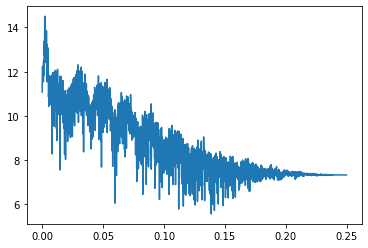

In [61]:
yf1 = fft.fft(filtered_data_unsure.T[:,540])
plt.figure()
plt.plot(xf,np.log(2.0/N * np.abs(yf1[:N//2])))
#plt.xlim(0,0.2)
plt.show()

In [62]:
smoothed_dat = np.load('gaussian_smoothed_11_2_2022_channels_7500_12500South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy')

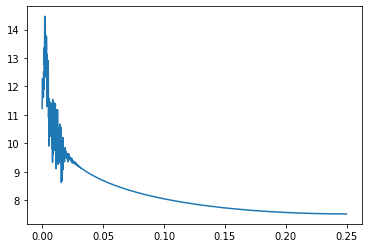

In [63]:
yf1 = fft.fft(smoothed_dat[:,540])
plt.figure()
plt.plot(xf,np.log(2.0/N * np.abs(yf1[:N//2])))
#plt.xlim(0,0.2)
plt.show()

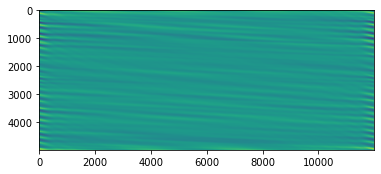

In [115]:
plt.imshow(sliced_data-fk_inv)
plt.show()

## Seems to work exceptionally

In [7]:
from obspy.signal import filter as obsfilt

In [40]:
lp_dat = obsfilt.lowpass(sliced_data.T, 2, 200, corners=1)#, zerophase=True)

In [80]:
np.amax(np.abs(filtered_data_unsure.T-sliced_data))

8185893.150049139

In [85]:
residuals1 = (filtered_data_unsure.T.flatten()-sliced_data.flatten())
residuals2 = (fk_inv.flatten()-sliced_data.flatten())

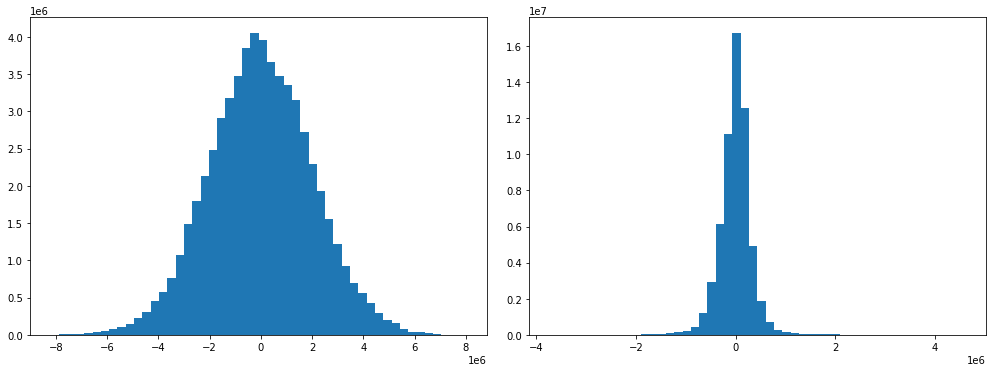

In [86]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,5))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
ax1.hist(residuals1,bins=50)
ax2.hist(residuals2,bins=50)
plt.show()

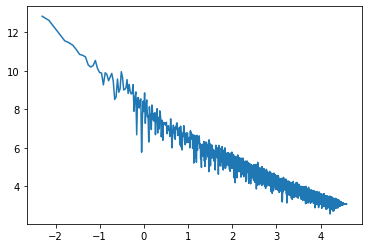

In [61]:
# N=5000
# yf1 = fft.fft(lp_dat.T[:,540])
N=12000
yf1 = fft.fft(lp_dat[:,540])
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fft.fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[5:-100],np.log(2.0/N * np.abs(yf1[1:N//2]))[5:-100])
#plt.xlim(0,0.2)
plt.show()



In [111]:
working_dat = lp_dat.T#[::10,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[1],working_dat.shape[0],1)

In [112]:
print(np.amax(working_dat))
print(np.amin(working_dat))

3.7986482218238686
-3.795542465558748


In [113]:
working_dat = working_dat[::10,::10,:]
working_dat.shape

(1200, 500, 1)

In [93]:
dt=1.
x = np.arange(working_dat.shape[1])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
    periodic=True
)

optimizer = ps.SR3(threshold=1e-3, max_iter=10, tol=1e-16, thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt)#,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

/home/ldoyle/packages/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 10 iterations.
  warnings.warn(


SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f78d0395d00>,
      feature_names=['x0'],
      optimizer=SR3(max_iter=10, normalize_columns=True, threshold=0.001,
                    thresholder='l1', tol=1e-16))

In [94]:
print("Ensemble SR3 ")
model.print()

Ensemble SR3 
(x0)' = 0.013 x0_1 + 0.002 x0_11 + 0.023 x0_111 + 0.003 x0_1111 + -0.001 x0x0_1 + -0.002 x0x0x0_1 + -0.003 x0x0_11 + -0.003 x0x0x0_11 + -0.001 x0x0_111 + -0.001 x0x0x0_111


In [35]:
dt=1.
x = np.arange(working_dat.shape[1])

optimizer = ps.STLSQ(threshold=10**(-5), alpha=1e-5, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

print("Ensemble STLSQ ")
model.print()

Ensemble STLSQ 
(x0)' = 0.005 x0_1 + 0.007 x0_111


In [114]:
dt=1.
x = np.arange(working_dat.shape[1])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
    periodic=True
)

optimizer = ps.STLSQ(threshold=6e-4, alpha=1e-6, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [115]:
model.print()

(x0)' = 0.034 x0_1 + 0.014 x0_111 + -0.002 x0x0_111 + -0.001 x0x0_1111


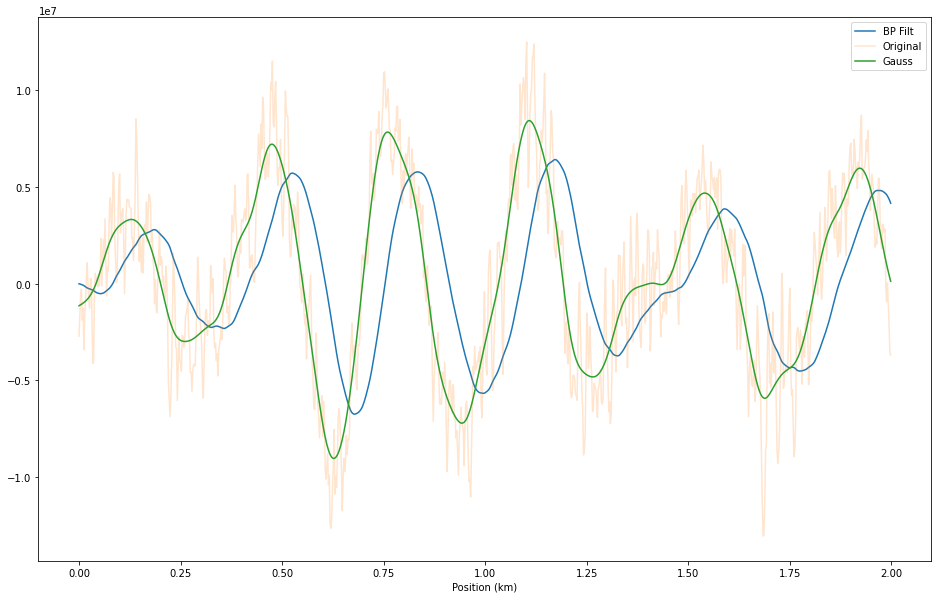

In [39]:
plt.figure(figsize=(16,10))
plt.plot((2/1000)*np.arange(1000), lp_dat[740,:1000], label="BP Filt")
plt.plot((2/1000)*np.arange(1000), data[7500:8500,740], label="Original", alpha=0.2)
plt.plot((2/1000)*np.arange(1000), smoothed_dat[:1000,740],label="Gauss")
plt.legend()
plt.xlabel("Position (km)")
plt.show()

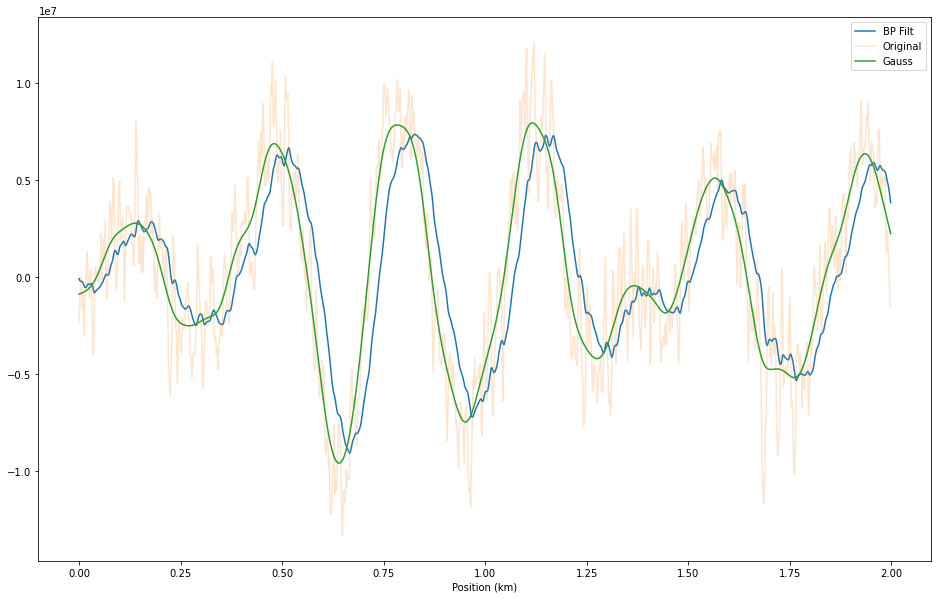

In [42]:
plt.figure(figsize=(16,10))
plt.plot((2/1000)*np.arange(1000), lp_dat[540,:1000], label="BP Filt")
plt.plot((2/1000)*np.arange(1000), data[7500:8500,540], label="Original", alpha=0.2)
plt.plot((2/1000)*np.arange(1000), smoothed_dat[:1000,540],label="Gauss")
plt.legend()
plt.xlabel("Position (km)")
plt.show()

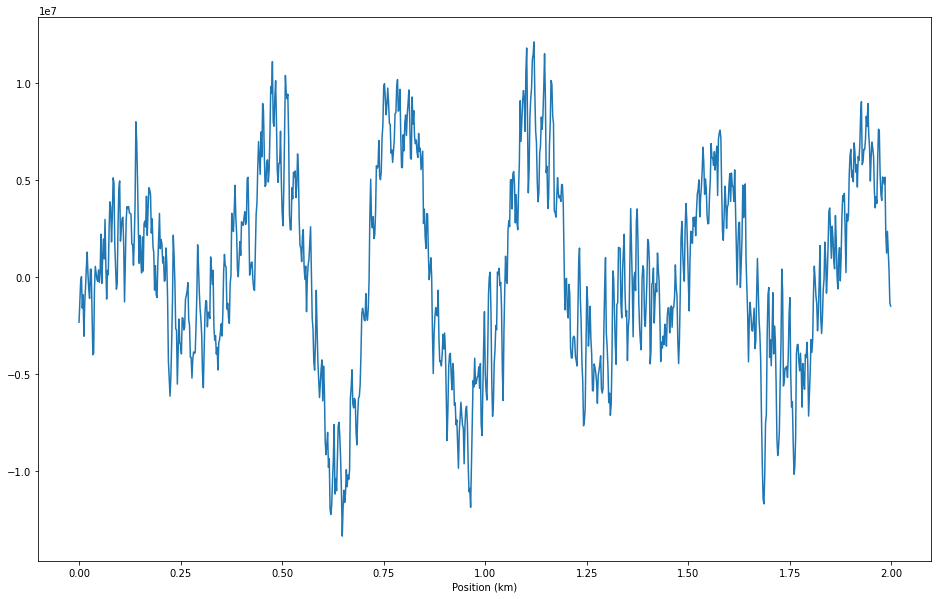

In [106]:
plt.figure(figsize=(16,10))
plt.plot((2/1000)*np.arange(1000), data[7500:8500,540])
plt.xlabel("Position (km)")
plt.show()

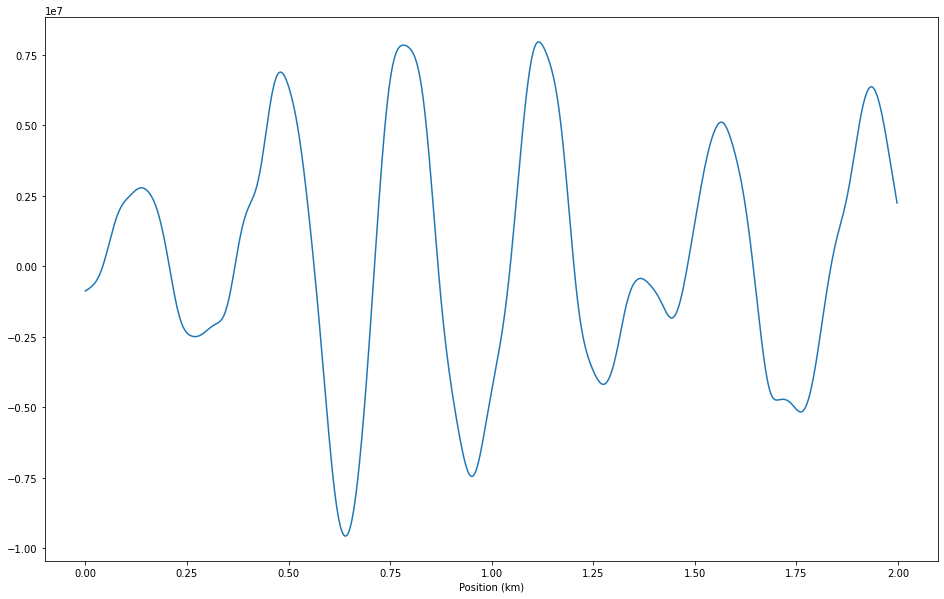

In [105]:
plt.figure(figsize=(16,10))
plt.plot((2/1000)*np.arange(1000), smoothed_dat[:1000,540])
plt.xlabel("Position (km)")
plt.show()